In [2]:
# %pip install Pylians
import numpy as np
import sys,os
# import readgadget
import MAS_library as MASL
import pickle as pk
# import readfof
# import matplotlib
from tqdm import tqdm
from nbodykit.source.catalog.file import BigFileCatalog
import nbodykit.lab as nb




In [2]:
def save_cic_densities(ji):
    try:
        root_in = '/mnt/ceph/users/cmodi/fastpm-shivam/fid_3Gpc/'
        root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/3gpc/'
        grids         = [384]
        BoxSize = 3000.0 #Mpc/h ; size of box
        n_batch = 8
        n_filter = 3
        n_cnn_all = [0,4]
        # snap_num_array = [4, 3, -1]
        snap_num_array = [3]
        # snap_num_array = [-1]
        # BoxSize = 1000.0    
        for grid in grids:
            # print('doing res: ' + str(grid))
            for snapnum in snap_num_array:
                z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 99}[snapnum]

                # create output folder if it does not exists
                folder_out = '%s/%d'%(root_out,ji)
                if not(os.path.exists(folder_out)):
                    os.system('mkdir %s'%folder_out)

                # file_names_all = []
                file_exists = True
                for n_cnn in n_cnn_all:
                    # find name of output file
                    savefname_density_subvol = '%s/density_HR_subvol_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
                    savefname_density_full = '%s/density_HR_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
                    # file_names_all.append(savefname_density_subvol)
                    # file_names_all.append(savefname_density_full)
                    if not(os.path.exists(savefname_density_subvol)):
                        file_exists = False
                        break
                
                    
                # if not file_exists:
                if 1:                
                    if snapnum == 4:
                        fname = '%s/%d' % (root_in, ji) + '/fastpm_B2_1.0000'
                        # df = nb.BigFileCatalog('/mnt/home/spandey/ceph/fastpm/LH_HR/' + str(js) + '/fastpm_B2_' + a, dataset='1')        
                        # pos = np.array(df['Position'], dtype=np.float64)
                    elif snapnum == 3:
                        fname = '%s/%d' % (root_in, ji) + '/fastpm_B2_0.6667'
                    elif snapnum == -1:
                        fname = '%s/%d' % (root_in, ji) + '/fastpm_B2_0.0100'                
                        # snapshot = '%s/%d' % (root_z99, ji)
                        # df_cic = np.load('%s/rho.npy'%(snapshot))
                    # df_pylians_cic = df_cic

                    # pos = np.array(df['Position'], dtype=np.float64)
                    # df.columns
                    df = nb.BigFileCatalog(fname, dataset='1')        
                    pos = np.array(df['Position'], dtype=np.float16)                
                    
                    # pos = np.array(df['Position'], dtype=np.float64)
                    df_pylians = np.zeros((grid,grid,grid), dtype=np.float32)
                    MASL.MA(np.float32(pos), df_pylians, BoxSize, 'CIC', verbose=False)
                    df_pylians_cic = df_pylians/np.mean(df_pylians, dtype=np.float32)-1.0


            
                    for n_cnn in n_cnn_all:
                        # find name of output file
                        savefname_density_subvol = '%s/density_HR_subvol_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
                        savefname_density_full = '%s/density_HR_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)

                        n_dim_red = (n_filter - 1) // 2
                        n_pad = n_dim_red * n_cnn
                        if n_cnn > 0:
                            df_cic_pad = np.pad(df_pylians_cic, n_pad, 'wrap')
                            # df_uniform_cic_pad = np.pad(df_uniform_cic_jax, n_pad, 'wrap')
                            # df_ngp_pad = np.pad(df_pylians_ngp, n_pad, 'wrap')
                        else:
                            df_cic_pad = df_pylians_cic
                            # df_uniform_cic_pad = df_uniform_cic_jax
                            # df_ngp_pad = df_pylians_ngp

                        # we want to split the df_pad into n_batch^3 sub-cubes, but centered on the original df simulation box
                        xstart, ystart, zstart = n_pad, n_pad, n_pad
                        subvol_size = grid // n_batch + 2 * n_pad
                        nsubvol = n_batch**3
                        save_subvol_density_cic_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                        # save_subvol_density_uniform_cic_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                        # save_subvol_density_ngp_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                        jc = 0
                        from tqdm import tqdm
                        for jx in (range(n_batch)):
                            for jy in range(n_batch):
                                for jz in range(n_batch):
                                    # get the sub-cube
                                    df_sub = df_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                                    ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                                    zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                                    # save the sub-cube
                                    save_subvol_density_cic_pad[jc, ...] = df_sub

                                    jc += 1

                        subvol_size = grid // n_batch
                        nsubvol = n_batch**3
                        save_subvol_density_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                        # save_subvol_density_uniform_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                        save_subvol_density_ngp_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                        jc = 0
                        
                        for jx in (range(n_batch)):
                            for jy in range(n_batch):
                                for jz in range(n_batch):
                                    # get the sub-cube
                                    save_subvol_density_cic_unpad[jc] = df_pylians_cic[jx * subvol_size:(jx + 1) * subvol_size,
                                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                                jz * subvol_size:(jz + 1) * subvol_size]
                                    
                                    jc += 1


                        saved_density_subvol = {
                            'density_cic_pad':save_subvol_density_cic_pad
                            }                        

                        pk.dump(saved_density_subvol, open(savefname_density_subvol, 'wb'))

                        saved_density_full = {
                            'density_cic_unpad_combined':df_pylians_cic
                            }                        

                        pk.dump(saved_density_full, open(savefname_density_full, 'wb'))


    except:
        pass


In [3]:
save_cic_densities(0)



/mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [4]:
def save_cic_densities(ji):
    try:
        root_in = '/mnt/ceph/users/cmodi/fastpm-shivam/fid_3Gpc/'
        root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/3gpc/'
        grids         = [384]
        BoxSize = 3000.0 #Mpc/h ; size of box
        n_batch = 8
        n_filter = 3
        n_cnn_all = [0,4]
        # snap_num_array = [4, 3, -1]
        snap_num_array = [3]  
    # for ji in tqdm(n_sim_array):
        # print('doing sim: ' + str(ji))
        for grid in grids:
            # print('doing res: ' + str(grid))
            for snapnum in snap_num_array:
                z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 99}[snapnum]

                # create output folder if it does not exists
                folder_out = '%s/%d'%(root_out,ji)
                if not(os.path.exists(folder_out)):
                    os.system('mkdir %s'%folder_out)

                # savefname_halos_subvol = '%s/halos_HR_subvol_res_%d_z=%s.pk'%(folder_out,grid,z)
                # savefname_halos_full = '%s/halos_HR_full_res_%d_z=%s.pk'%(folder_out,grid,z)            
                
                # compute the density field and save it to file
                if snapnum == 4:
                    fname = '%s/%d' % (root_in, ji) + '/fastpm_B2_1.0000'
                    # df = nb.BigFileCatalog('/mnt/home/spandey/ceph/fastpm/LH_HR/' + str(js) + '/fastpm_B2_' + a, dataset='1')        
                    # pos = np.array(df['Position'], dtype=np.float64)
                elif snapnum == 3:
                    fname = '%s/%d' % (root_in, ji) + '/fastpm_B2_0.6667'
                elif snapnum == -1:
                    fname = '%s/%d' % (root_in, ji) + '/fastpm_B2_0.0100'                
                    # snapshot = '%s/%d' % (root_z99, ji)
                    # df_cic = np.load('%s/rho.npy'%(snapshot))
                # df_pylians_cic = df_cic

                # pos = np.array(df['Position'], dtype=np.float64)
                # df.columns
                df = nb.BigFileCatalog(fname, dataset='1')        
                pos = np.array(df['Position'], dtype=np.float16)     
                pvel = np.array(df['Velocity'], dtype=np.float16)                           
                
                # pos = np.array(df['Position'], dtype=np.float64)
                rho_m_orig = np.zeros((grid,grid,grid), dtype=np.float32)
                MASL.MA(np.float32(pos), rho_m_orig, BoxSize, 'CIC', verbose=False)


                mom_m_x_orig = np.zeros((grid,grid,grid), dtype=np.float32)                
                MASL.MA(np.float32(pos), mom_m_x_orig, BoxSize, 'CIC', verbose=False, W=pvel[:,0].astype(np.float32))
                mom_m_y_orig = np.zeros((grid,grid,grid), dtype=np.float32)                
                MASL.MA(np.float32(pos), mom_m_y_orig, BoxSize, 'CIC', verbose=False, W=pvel[:,1].astype(np.float32))
                mom_m_z_orig = np.zeros((grid,grid,grid), dtype=np.float32)                
                MASL.MA(np.float32(pos), mom_m_z_orig, BoxSize, 'CIC', verbose=False, W=pvel[:,2].astype(np.float32))                

                vel_m_x_orig = mom_m_x_orig/rho_m_orig
                vel_m_y_orig = mom_m_y_orig/rho_m_orig
                vel_m_z_orig = mom_m_z_orig/rho_m_orig

                # at voxels with non-finite values, set velocities to zero:
                vel_m_x_orig[~np.isfinite(vel_m_x_orig)] = 0.0
                vel_m_y_orig[~np.isfinite(vel_m_y_orig)] = 0.0
                vel_m_z_orig[~np.isfinite(vel_m_z_orig)] = 0.0

                # divide out by 1000.:
                vel_m_x_orig /= 1000.
                vel_m_y_orig /= 1000.
                vel_m_z_orig /= 1000.

                vel_m_all_orig = np.stack((vel_m_x_orig, vel_m_y_orig, vel_m_z_orig), axis=0)

                for n_cnn in n_cnn_all:
                    # find name of output file
                    savefname_density_subvol = '%s/velocity_HR_subvol_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
                    savefname_density_full = '%s/velocity_HR_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)

                    n_dim_red = (n_filter - 1) // 2
                    n_pad = n_dim_red * n_cnn
                    if n_cnn > 0:
                        # df_cic_pad = np.pad(df_pylians_cic, n_pad, 'wrap')
                        rho_m_cic_pad = np.pad(rho_m_orig, n_pad, 'wrap')
                        mom_m_x_cic_pad = np.pad(mom_m_x_orig, n_pad, 'wrap')
                        mom_m_y_cic_pad = np.pad(mom_m_y_orig, n_pad, 'wrap')
                        mom_m_z_cic_pad = np.pad(mom_m_z_orig, n_pad, 'wrap')

                    else:
                        rho_m_cic_pad = rho_m_orig
                        mom_m_x_cic_pad = mom_m_x_orig
                        mom_m_y_cic_pad = mom_m_y_orig
                        mom_m_z_cic_pad = mom_m_z_orig

                    vel_m_x_cic_pad = mom_m_x_cic_pad/rho_m_cic_pad
                    vel_m_y_cic_pad = mom_m_y_cic_pad/rho_m_cic_pad
                    vel_m_z_cic_pad = mom_m_z_cic_pad/rho_m_cic_pad

                    # at voxels with non-finite values, set velocities to zero:
                    vel_m_x_cic_pad[~np.isfinite(vel_m_x_cic_pad)] = 0.0
                    vel_m_y_cic_pad[~np.isfinite(vel_m_y_cic_pad)] = 0.0
                    vel_m_z_cic_pad[~np.isfinite(vel_m_z_cic_pad)] = 0.0

                    # divide out by 1000.:
                    vel_m_x_cic_pad /= 1000.
                    vel_m_y_cic_pad /= 1000.
                    vel_m_z_cic_pad /= 1000.

                    vel_m_all_cic_pad = np.stack((vel_m_x_cic_pad, vel_m_y_cic_pad, vel_m_z_cic_pad), axis=0)
                        # df_uniform_cic_pad = df_uniform_cic_jax
                        # df_ngp_pad = df_pylians_ngp

                    # we want to split the df_pad into n_batch^3 sub-cubes, but centered on the original df simulation box
                    xstart, ystart, zstart = n_pad, n_pad, n_pad
                    subvol_size = grid // n_batch + 2 * n_pad
                    nsubvol = n_batch**3
                    save_subvol_velocity_cic_pad = np.zeros((nsubvol, 3, subvol_size, subvol_size, subvol_size))
                    # save_subvol_density_uniform_cic_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    # save_subvol_density_ngp_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    jc = 0
                    # from tqdm import tqdm
                    for jx in (range(n_batch)):
                        for jy in range(n_batch):
                            for jz in range(n_batch):
                                # get the sub-cube
                                save_subvol_velocity_cic_pad[jc, 0, ...]  = vel_m_x_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                                ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                                zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]

                                save_subvol_velocity_cic_pad[jc, 1, ...]  = vel_m_y_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                                ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                                zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]

                                save_subvol_velocity_cic_pad[jc, 2, ...]  = vel_m_z_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                                ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                                zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]                                                                                                
                                # save the sub-cube

                                jc += 1

                    subvol_size = grid // n_batch
                    nsubvol = n_batch**3
                    save_subvol_velocity_cic_unpad = np.zeros((nsubvol, 3, subvol_size, subvol_size, subvol_size))
                    # save_subvol_density_uniform_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    # save_subvol_density_ngp_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    jc = 0
                    
                    for jx in (range(n_batch)):
                        for jy in range(n_batch):
                            for jz in range(n_batch):
                                # get the sub-cube
                                save_subvol_velocity_cic_unpad[jc, 0, ...] = vel_m_x_orig[jx * subvol_size:(jx + 1) * subvol_size,
                                                            jy * subvol_size:(jy + 1) * subvol_size,
                                                            jz * subvol_size:(jz + 1) * subvol_size]
                                
                                save_subvol_velocity_cic_unpad[jc, 1, ...] = vel_m_y_orig[jx * subvol_size:(jx + 1) * subvol_size,
                                                            jy * subvol_size:(jy + 1) * subvol_size,
                                                            jz * subvol_size:(jz + 1) * subvol_size]
                                
                                save_subvol_velocity_cic_unpad[jc, 2, ...] = vel_m_z_orig[jx * subvol_size:(jx + 1) * subvol_size,
                                                            jy * subvol_size:(jy + 1) * subvol_size,
                                                            jz * subvol_size:(jz + 1) * subvol_size]

                                jc += 1


                    saved_density_subvol = {
                        'velocity_cic_pad':save_subvol_velocity_cic_pad,
                        # 'density_uniform_cic_pad':save_subvol_density_uniform_cic_pad,
                        # 'density_ngp_pad':save_subvol_density_ngp_pad,
                        'velocity_cic_unpad':save_subvol_velocity_cic_unpad,
                        # 'density_ngp_unpad':save_subvol_density_ngp_unpad,
                        # 'density_uniform_cic_unpad':save_subvol_density_uniform_cic_unpad
                        }                        

                    pk.dump(saved_density_subvol, open(savefname_density_subvol, 'wb'))

                    saved_density_full = {
                        'velocity_cic_unpad_combined':vel_m_all_orig,
                        # 'density_uniform_cic_unpad_combined':df_uniform_cic_jax,
                        # 'density_ngp_unpad_combined':df_pylians_ngp,                                
                        'velocity_cic_pad_combined':vel_m_all_cic_pad,
                        # 'density_ngp_pad_combined':df_ngp_pad,
                        # 'density_uniform_cic_pad_combined':df_uniform_cic_pad                                            
                        }                        

                    pk.dump(saved_density_full, open(savefname_density_full, 'wb'))
    except:
        pass



In [5]:
save_cic_densities(0)




In [4]:
# test the densities between 1gpc and 3gpc boxes:

# ldir = '/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/3gpc/'
dfname = '/mnt/ceph/users/spandey/Quijote/data_NGP_self/fastpm/3gpc/0/density_HR_full_m_res_384_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk'
df = pk.load(open(dfname, 'rb'))
rho_3gpc = df['density_cic_unpad_combined']


In [7]:
dfname = '/mnt/ceph/users/spandey/Quijote/data_NGP_self/fastpm/0/density_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk'
df = pk.load(open(dfname, 'rb'))
# df.keys()
rho_1gpc = df['density_cic_unpad_combined']


In [8]:
import matplotlib.pyplot as pl
%matplotlib inline



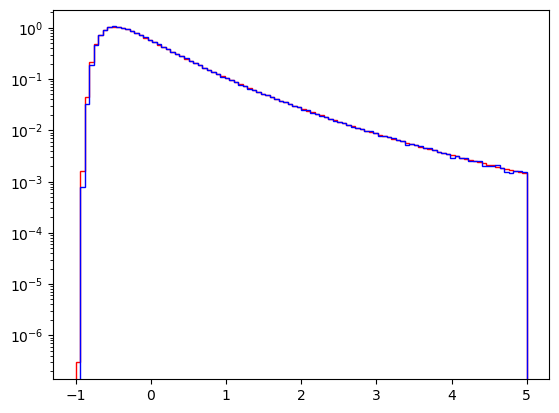

In [10]:
pl.figure()
_ = pl.hist(rho_3gpc.flatten(), bins=100, histtype='step', color='r', label='3gpc', range=(-1,5), density=True)
_ = pl.hist(rho_1gpc.flatten(), bins=100, histtype='step', color='b', label='1gpc', range=(-1,5), density=True)
pl.yscale('log')